In [3388]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "serif"

Let's do some preliminary analysis.

### sales
1. dimensions of the dataset;
2. data cleaning 	
	1. remove the empty columns and rows;
	2. check for null columns (each entry is `NaN`) / check for null rows;
	3. check types;
	4. `date`:
		- check range;
	5. `is_open`:
		- check is composed by `YES` and `NO` only;
		- edit the exeptions; 
	6. `sales_amount`: 
		- impose `if is_open == "NO" then sales_amount = 0` (and fix exeptions);
		- check if all values are non-negative (NO!);
		- edit negatives and `NaN`;

### market
1. dimensions of the dataset;
2. data cleaning 	
	1. remove the empty columns and rows;
	2. check for null columns (each entry is `NaN`) / check for null rows;
	3. check types;
	4. `id`:
		- unique identifier;
	5. `market_type`:
		- check is composed by correct labels;
	6. `squere_feet`: 
		- check positive; 
	5. `market_type`:
      	- solve `NaN` values;
	6. `avg_customer`: 
		- check positive (and correct);
		- set integer;
	7. `competitor_distance`: 
        - check positive;
	8. `has_promotions`:
		- check is composed by `YES` and `NO` only;

# sales

In [3389]:
sales = pd.read_csv("data/sales.csv")
display(sales)

,market_id,date,is_open,sales_amount,
0,XC14,31/12/2022,YES,55727.34,NaN
1,WG25,31/12/2022,YES,12984.10,NaN
2,UX72,31/12/2022,YES,13046.56,NaN
3,EE84,31/12/2022,YES,60916.76,NaN
4,RF54,31/12/2022,YES,12376.42,NaN
...,...,...,...,...,...
523944,ZM74,01/01/2021,YES,21553.84,NaN
523945,WW60,01/01/2021,YES,56371.18,NaN
523946,LU14,01/01/2021,YES,24107.19,NaN
523947,HY57,01/01/2021,YES,12257.38,NaN


## 1

dimensions of the dataset

In [3390]:
n_rows_sales = sales.shape[0]
n_cols_sales = sales.shape[1]
print("the number of rows is " + str(n_rows_sales) + " while the number of columns is " + str(n_cols_sales))

the number of rows is 523949 while the number of columns is 5


## 2

### 2.1

In [3391]:
# remove empty colums
sales = sales.dropna(axis = 1, how = "all")
n_cols_sales = sales.shape[1]

# remove empty rows
sales = sales.dropna(axis = 0, how = "all")
n_rows_sales = sales.shape[0]
	
display(sales)

,market_id,date,is_open,sales_amount
0,XC14,31/12/2022,YES,55727.34
1,WG25,31/12/2022,YES,12984.10
2,UX72,31/12/2022,YES,13046.56
3,EE84,31/12/2022,YES,60916.76
4,RF54,31/12/2022,YES,12376.42
...,...,...,...,...
523944,ZM74,01/01/2021,YES,21553.84
523945,WW60,01/01/2021,YES,56371.18
523946,LU14,01/01/2021,YES,24107.19
523947,HY57,01/01/2021,YES,12257.38


### 2.2

check for NaN

In [3392]:
n_nan = sales.isnull().sum().sum()
print("the total number of NaN is " + str(n_nan) + "\n")

print("the number of NaN in each column of sales is:")
for index in range(0, n_cols_sales):
	col = sales.iloc[:, index]
	n_nan_col = col.isnull().sum().sum()
	print("- " + sales.columns[index] + " = " + str(n_nan_col))

the total number of NaN is 14

the number of NaN in each column of sales is:
- market_id = 0
- date = 0
- is_open = 0
- sales_amount = 14


(commento) siccome i NaN sono solo in sales_amount bisogna capire come trattarli

### 2.3


check types

In [3393]:
sales.dtypes

market_id        object
date             object
is_open          object
sales_amount    float64
dtype: object

### 2.4

check range of date

In [3394]:
sales["date"] = pd.to_datetime(sales["date"], format = "%d/%m/%Y")
start_date = "01/01/2021"
end_date = "31/12/2022"

# boolean panda's series: True if the date is acceptable (inside the range), False otherwise
check_date_range = sales["date"].between(start_date, end_date)

n_date_out_of_range = n_rows_sales - check_date_range.sum()
print("the number of dates out of range is " + str(n_date_out_of_range))

the number of dates out of range is 0


### 2.5

check is_open is compesed only by yes and no

In [3395]:
# boolean panda's series: True if is_open is acceptable ("YES" or "NO"), False otherwise
check_is_open = sales[~sales["is_open"].isin(["YES", "NO"])].index
print("the rows with no YES or NO in is_open are: " + str(list(check_is_open)))

display(sales.loc[check_is_open, :])

the rows with no YES or NO in is_open are: [49154]


,market_id,date,is_open,sales_amount
49154,BT51,2022-10-14,YESS,25220.48


(commento)

In [3396]:
sales.loc[check_is_open[0], "is_open"] = "YES"

### 2.6

controlliamo che i NO abbiano sales_amount uguale a 0 e li correggiamo

In [3397]:
# sales dataframe restricted to the condition is_open == "NO" with non-acceptable sales_amounts (!= 0)
sales_amount_no_error = sales[(sales["is_open"] == "NO") & (sales["sales_amount"] != 0)]
print("indexes where is_open is NO and sales_amount is not 0: " + str(list(sales_amount_no_error.index)))
sales.loc[sales_amount_no_error.index, "sales_amount"] = 0

indexes where is_open is NO and sales_amount is not 0: [753]


In [3398]:
# sales dataframe restricted to the condition sales_amounts < 0
sales_amount_negative = sales[sales["sales_amount"] < 0]
sales_amount_negative

,market_id,date,is_open,sales_amount
47528,XC14,2022-10-16,YES,-999999.0
48150,XC14,2022-10-15,YES,-999999.0
48772,XC14,2022-10-14,YES,-999999.0
49394,XC14,2022-10-13,YES,-999999.0
50016,XC14,2022-10-12,YES,-999999.0
50638,XC14,2022-10-11,YES,-999999.0


trattiamo i dati negativi e NaN allo stesso modo: sostituiamo il valore con la media dei sales_amount dello stesso market <br>
(commento: altra opzione sarebbe mettere media sullo stesso giorno con market dello stesso tipo nello stessa nazione)

correcting errors: we iterate over the non-acceptable rows of the sales dataframe, subsituting the wrong sales_amounts with the previously computed mean

In [3399]:
# sales dataframe restricted to the rows with non-acceptable sales_amounts (NaN or negative values)
sales_amount_error = sales[sales["sales_amount"].isnull() | (sales["sales_amount"] < 0)]
display(sales_amount_error)

# dataframe containing the market_id's and their correspondent mean sales_amount
mean_sales_amount = (sales[(sales["sales_amount"] > 0)].groupby("market_id"))["sales_amount"].mean()

# correcting errors
for index, row in (sales.loc[sales_amount_error.index]).iterrows():
	sales.loc[index, "sales_amount"] = mean_sales_amount[row["market_id"]]
# portion of the dataframe corrected
sales.loc[sales_amount_error.index]

,market_id,date,is_open,sales_amount
98,OG21,2022-12-31,YES,NaN
47528,XC14,2022-10-16,YES,-999999.0
48150,XC14,2022-10-15,YES,-999999.0
48772,XC14,2022-10-14,YES,-999999.0
49394,XC14,2022-10-13,YES,-999999.0
50016,XC14,2022-10-12,YES,-999999.0
50638,XC14,2022-10-11,YES,-999999.0
174088,UF73,2022-04-12,YES,NaN
223239,BY57,2022-02-05,YES,NaN
509998,NL22,2021-01-19,YES,NaN


,market_id,date,is_open,sales_amount
98,OG21,2022-12-31,YES,62768.862528
47528,XC14,2022-10-16,YES,60603.900400
48150,XC14,2022-10-15,YES,60603.900400
48772,XC14,2022-10-14,YES,60603.900400
49394,XC14,2022-10-13,YES,60603.900400
50016,XC14,2022-10-12,YES,60603.900400
50638,XC14,2022-10-11,YES,60603.900400
174088,UF73,2022-04-12,YES,12005.331014
223239,BY57,2022-02-05,YES,12628.222322
509998,NL22,2021-01-19,YES,12017.349917


# market

In [3400]:
market = pd.read_csv("data/market.csv")
display(market)

,id,country,Unnamed: 2,market_type,square_feet,avg_customers,competitor_distance,has_promotions
0,XC14,SPAIN,NaN,HYPER,11135,773.0,515,YES
1,WG25,FRANCE,NaN,MINI,1402,252.0,522,YES
2,UX72,FRANCE,NaN,MINI,1452,265.0,15939,YES
3,EE84,SPAIN,NaN,HYPER,15259,874.0,754,YES
4,RF54,FRANCE,NaN,MINI,2497,191.0,34007,YES
...,...,...,...,...,...,...,...,...
745,ZM74,ITALY,NaN,SUPER,5778,356.0,4424,YES
746,WW60,FRANCE,NaN,HYPER,10923,907.0,41359,YES
747,LU14,ITALY,NaN,SUPER,5742,397.0,2841,YES
748,HY57,ITALY,NaN,MINI,2495,228.0,3848,YES


## 1

dimensions of the dataset

In [3401]:
n_rows_market = market.shape[0]
n_cols_market = market.shape[1]
print("the number of rows is " + str(n_rows_market) + " while the number of columns is " + str(n_cols_market))

the number of rows is 750 while the number of columns is 8


## 2

### 2.1

In [3402]:
# remove empty colums
market = market.dropna(axis = 1, how = "all")
n_cols_market = market.shape[1]

# remove empty rows
market = market.dropna(axis = 0, how = "all")
n_rows_market = market.shape[0]
	
display(market)

,id,country,market_type,square_feet,avg_customers,competitor_distance,has_promotions
0,XC14,SPAIN,HYPER,11135,773.0,515,YES
1,WG25,FRANCE,MINI,1402,252.0,522,YES
2,UX72,FRANCE,MINI,1452,265.0,15939,YES
3,EE84,SPAIN,HYPER,15259,874.0,754,YES
4,RF54,FRANCE,MINI,2497,191.0,34007,YES
...,...,...,...,...,...,...,...
745,ZM74,ITALY,SUPER,5778,356.0,4424,YES
746,WW60,FRANCE,HYPER,10923,907.0,41359,YES
747,LU14,ITALY,SUPER,5742,397.0,2841,YES
748,HY57,ITALY,MINI,2495,228.0,3848,YES


### 2.2

check for NaN

In [3403]:
n_nan = market.isnull().sum().sum()
print("the total number of NaN is " + str(n_nan) + "\n")

print("the number of NaN in each column of market is:")
for index in range(0, n_cols_market):
	col = market.iloc[:, index]
	n_nan_col = col.isnull().sum().sum()
	print("- " + market.columns[index] + " = " + str(n_nan_col))

the total number of NaN is 3

the number of NaN in each column of market is:
- id = 0
- country = 0
- market_type = 2
- square_feet = 0
- avg_customers = 1
- competitor_distance = 0
- has_promotions = 0


### 2.3

In [3404]:
market.dtypes

id                      object
country                 object
market_type             object
square_feet              int64
avg_customers          float64
competitor_distance      int64
has_promotions          object
dtype: object

c'è un problema: avg_customers è float, invece noi lo si vuole int. Gli altri tipi vanno bene

### 2.4

In [3405]:
print("the market id's are unique:", len(market) == len(pd.unique(market["id"])))

the market id's are unique: True


### 2.5

check market_type is compesed only by correct labels

In [3406]:
# boolean panda's series: True if market_type is acceptable ("MINI", "SUPER" or "HYPER"), False otherwise
check_market_type = market[~market["market_type"].isin(["MINI", "SUPER", "HYPER"])].index
print("the rows with non correct labels are: " + str(list(check_market_type)))

display(market.loc[check_market_type, :])

the rows with non correct labels are: [90, 225]


,id,country,market_type,square_feet,avg_customers,competitor_distance,has_promotions
90,RU30,SPAIN,NaN,14305,637.0,1701,YES
225,KB10,ITALY,NaN,1520,150.0,479,YES


### 2.6

In [3407]:
# boolean panda's series: True if square_feet is positive, False otherwise
check_square_feet = market[market["square_feet"] <= 0].index
print("the rows with negative square_feet are: " + str(list(check_square_feet)))

the rows with negative square_feet are: []


### 2.7

In [3408]:
# market without uncorrect market_type 
market_correct = market.iloc[~market.index.isin(check_market_type)]

# dataframe containing the country, the market_type and their correspondent mean square_feet
mean_sqfeet_bycountry = (market_correct.groupby(["country", "market_type"]))["square_feet"].mean()
display(pd.DataFrame(mean_sqfeet_bycountry))

square_feet
country market_type              
FRANCE  HYPER        12153.225806
        MINI          1998.402778
        SUPER         6035.285714
ITALY   HYPER        12052.172414
        MINI          2054.526786
        SUPER         6067.655172
SPAIN   HYPER        12063.774194
        MINI          1978.367089
        SUPER         6079.606061

tra le nazioni le medie degli square_feet non sono particolarmente diverse (per market_type)

correcting errors: we iterate over the non-acceptable rows of the market dataframe, subsituting the NaN values with the market type corresponding with the closest (in terms of square_feet) market_type in the same country

In [3409]:
# correcting errors
for index, row in market.loc[check_market_type, :].iterrows():
	# panda's series with the square_feet means with respect to market_type in the country row["country"]
	mean_sqfeet_country = mean_sqfeet_bycountry[row["country"]]
	# closest square_feet value within the previous pandas series
	closest_sqfeet = min(mean_sqfeet_country, key = lambda x: abs(row["square_feet"] - x))
	# corresponding market_type
	closest_market_type = (mean_sqfeet_country[mean_sqfeet_country == closest_sqfeet]).index[0]
	# assigning the market_type
	market.loc[index, "market_type"] = closest_market_type

# corrected rows
display(market.loc[check_market_type, :])

,id,country,market_type,square_feet,avg_customers,competitor_distance,has_promotions
90,RU30,SPAIN,HYPER,14305,637.0,1701,YES
225,KB10,ITALY,MINI,1520,150.0,479,YES


abbiamo mostrato con un loop come modificare i dati errati sebbene fossero solo 2, in quanto in contesti generici sarebbero potuti essere decine o centinaia i valori mancanti

### 2.8

In [3410]:
# boolean panda's series: True if avg_customers is acceptable (not NaN or negative), False otherwise
check_avg_customers = market[market["avg_customers"].isnull() | (market["avg_customers"] < 0)].index
print("the rows with non acceptable values are: " + str(list(check_avg_customers)))

display(market.loc[check_avg_customers, :])

the rows with non acceptable values are: [69, 626]


,id,country,market_type,square_feet,avg_customers,competitor_distance,has_promotions
69,IP89,SPAIN,HYPER,15560,-9999.0,6281,YES
626,OD40,ITALY,HYPER,14157,NaN,3519,YES


(stessa roba di prima, non necessita commenti)

In [3411]:
market_correct = market.iloc[~market.index.isin(check_avg_customers)]
mean_avgcust_bycountry = (market_correct.groupby(["country", "market_type"]))["avg_customers"].mean()
display(pd.DataFrame(mean_avgcust_bycountry))

for index, row in market.loc[check_avg_customers, :].iterrows():
	market.loc[index, "avg_customers"] = mean_avgcust_bycountry[row["country"]][row["market_type"]]

display(market.loc[check_avg_customers, :])

avg_customers
country market_type               
FRANCE  HYPER           688.258065
        MINI            210.527778
        SUPER           401.396825
ITALY   HYPER           733.785714
        MINI            208.646018
        SUPER           401.293103
SPAIN   HYPER           763.483871
        MINI            214.329114
        SUPER           405.333333

,id,country,market_type,square_feet,avg_customers,competitor_distance,has_promotions
69,IP89,SPAIN,HYPER,15560,763.483871,6281,YES
626,OD40,ITALY,HYPER,14157,733.785714,3519,YES


tra le nazioni le medie degli avg_customers non sono particolarmente diverse (per market_type)

In [3412]:
market["avg_customers"] = market["avg_customers"].round().astype('int')
display(market.loc[check_avg_customers, :])

,id,country,market_type,square_feet,avg_customers,competitor_distance,has_promotions
69,IP89,SPAIN,HYPER,15560,763,6281,YES
626,OD40,ITALY,HYPER,14157,734,3519,YES


### 2.9

In [3413]:
# boolean panda's series: True if competitor_distance is positive, False otherwise
check_competitor_distance = market[market["competitor_distance"] <= 0].index
print("the rows with negative competitor_distance are: " + str(list(check_square_feet)))

the rows with negative competitor_distance are: []


### 2.10

In [3414]:
# boolean panda's series: True if has_promotions is acceptable ("YES" or "NO"), False otherwise
check_has_promotions = market[~market["has_promotions"].isin(["YES", "NO"])].index
print("the rows with non correct values are: " + str(list(check_has_promotions)))

# display(market.loc[check_has_promotions, :])

the rows with non correct values are: []


# dataset

## build dataset

collapse temporal information of sales

In [3415]:
sales["is_open"] = sales["is_open"].map({"YES": 1, "NO": 0})
sales = sales.groupby("market_id")[["is_open", "sales_amount"]].mean().reset_index()
display(sales)

,market_id,is_open,sales_amount
0,AA39,0.827397,10433.131548
1,AA82,0.820513,21804.155256
2,AB90,0.830137,21686.734197
3,AC71,0.820513,9728.267912
4,AD13,0.824658,10219.610630
...,...,...,...
745,ZX46,0.830137,10435.278082
746,ZX76,0.820513,10154.048388
747,ZY62,0.827397,21847.301630
748,ZZ11,0.818681,10268.111154


merge datasets

In [3416]:
merged_df = pd.merge(sales, market, left_on = "market_id", right_on = "id", how = "left").drop(["market_id", "id"], axis = 1)
merged_df

,is_open,sales_amount,country,market_type,square_feet,avg_customers,competitor_distance,has_promotions
0,0.827397,10433.131548,FRANCE,MINI,2437,248,58,YES
1,0.820513,21804.155256,FRANCE,SUPER,6403,493,300,YES
2,0.830137,21686.734197,FRANCE,SUPER,7544,340,1598,YES
3,0.820513,9728.267912,SPAIN,MINI,1940,165,2068,YES
4,0.824658,10219.610630,FRANCE,MINI,1486,166,750,YES
...,...,...,...,...,...,...,...,...
745,0.830137,10435.278082,FRANCE,MINI,1691,272,1843,YES
746,0.820513,10154.048388,FRANCE,MINI,1462,159,547,YES
747,0.827397,21847.301630,FRANCE,SUPER,5946,488,2743,YES
748,0.818681,10268.111154,FRANCE,MINI,1413,239,1920,YES


## data_visualization

### boxplots

boxplots of quantitative variables

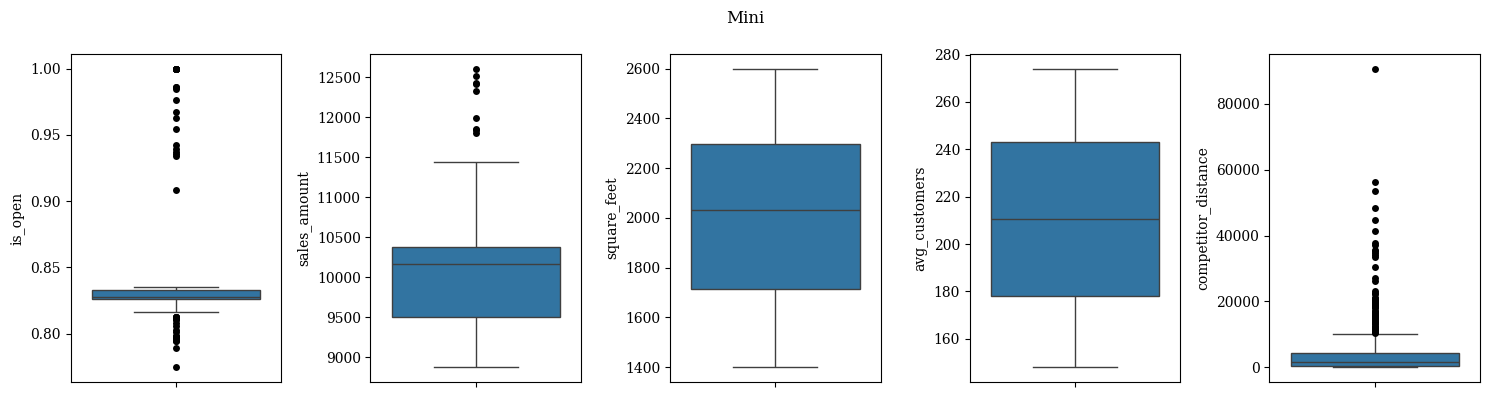

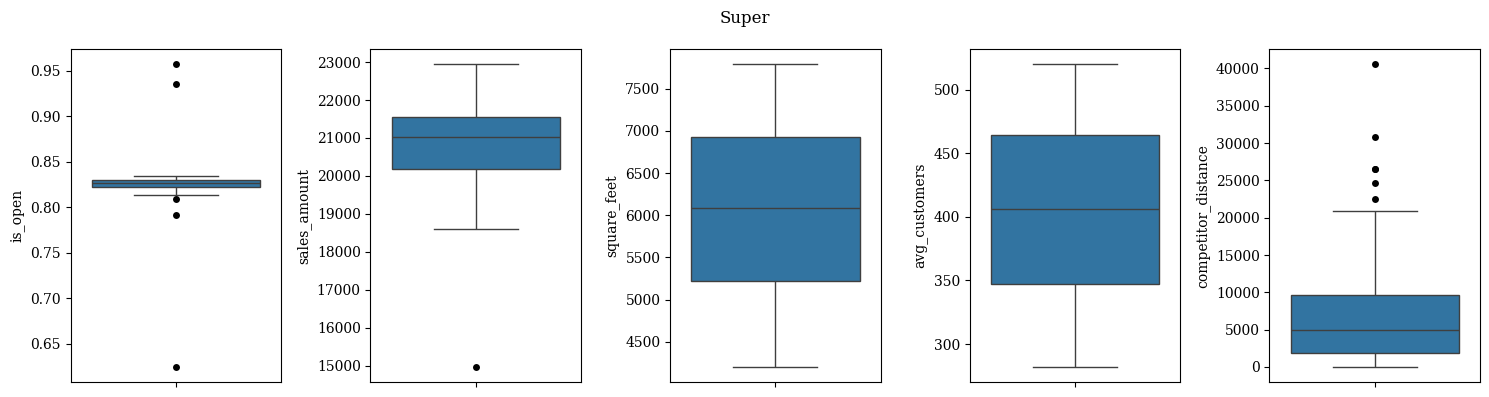

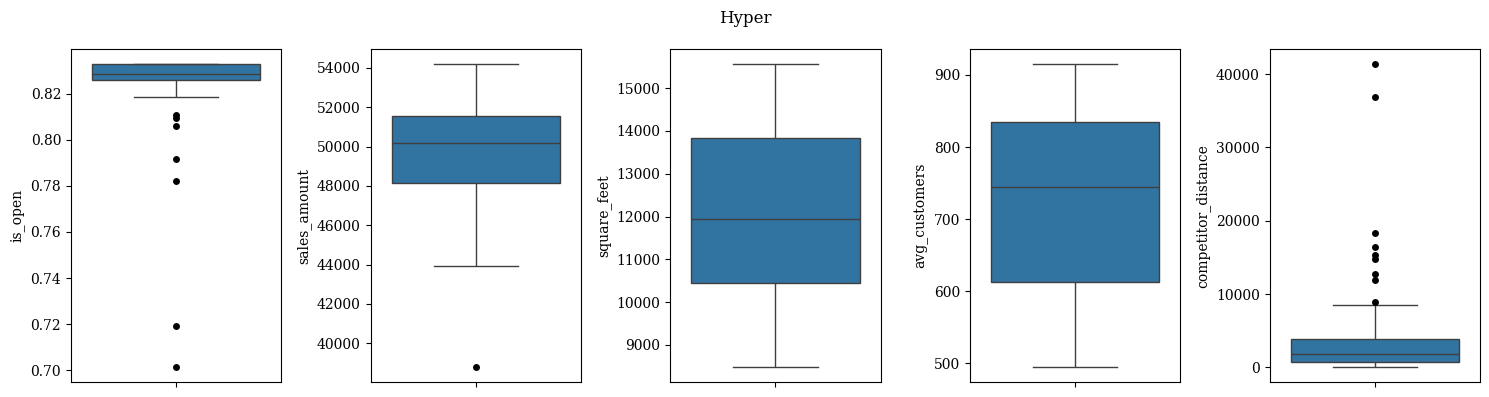

In [3417]:
quant_names = ["is_open", "sales_amount", "square_feet", "avg_customers", "competitor_distance"]
for market_type in pd.unique(merged_df["market_type"]):
	merged_df_mt = merged_df[merged_df["market_type"] == market_type]

	fig, ax = plt.subplots(ncols = 5, nrows = 1, figsize = (15, 4))
	ax = ax.flatten()
	index = 0
	for col_name in quant_names:
		sns.boxplot(y = col_name, data = merged_df_mt, ax = ax[index],
			flierprops = {"marker": ".", "markersize": 10, "markerfacecolor": "black", "markeredgecolor": "none"})
		index += 1
	fig.suptitle(market_type.title())
	plt.tight_layout()
	plt.show()

It seems there are some outliers, let's see the outlier percentage per column. <br>
To check outliers (before fitting the model), one standard approach is to compute the `iqr` (interquartile range) and then check values that are:
- lower than $\text{quantile}(0.25) - 1.5 \cdot \text{iqr}$  or
- greater than $\text{quantile}(0.75) + 1.5 \cdot \text{iqr}$.

In [3418]:
for market_type in pd.unique(merged_df["market_type"]):
	merged_df_mt = merged_df[merged_df["market_type"] == market_type].drop("market_type", axis = 1)
	
	print(str(market_type.title()) + ":")
	for col_name, col in merged_df_mt[quant_names].items():
		q1 = col.quantile(0.25)
		q3 = col.quantile(0.75)
		iqr = q3 - q1
		outliers_col = col[(col <= q1 - 1.5 * iqr) | (col >= q3 + 1.5 * iqr)]
		print("\t - " + col_name + ": " + str(round(len(outliers_col) / len(col) * 100, 2)) + "%")

Mini:
	 - is_open: 10.54%
	 - sales_amount: 2.21%
	 - square_feet: 0.0%
	 - avg_customers: 0.0%
	 - competitor_distance: 15.2%
Super:
	 - is_open: 2.0%
	 - sales_amount: 0.4%
	 - square_feet: 0.0%
	 - avg_customers: 0.0%
	 - competitor_distance: 2.4%
Hyper:
	 - is_open: 7.61%
	 - sales_amount: 1.09%
	 - square_feet: 0.0%
	 - avg_customers: 0.0%
	 - competitor_distance: 9.78%


### countplots

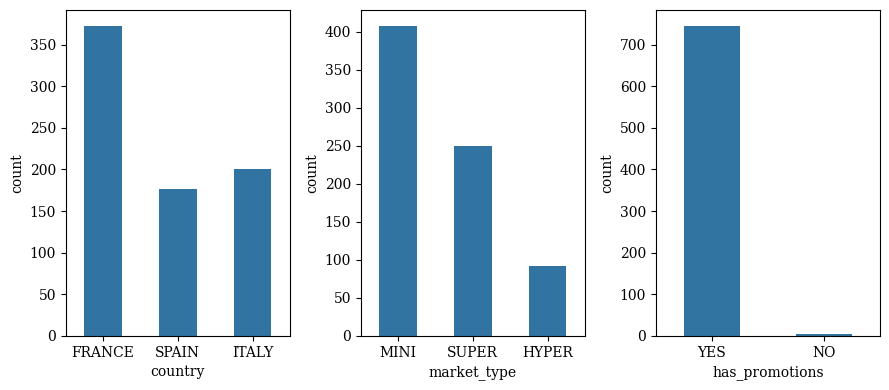

In [3419]:
cat_names = ["country", "market_type", "has_promotions"]
fig, ax = plt.subplots(ncols = 3, nrows = 1, figsize = (9, 4))
index = 0
ax = ax.flatten()
for col_name in cat_names:
	sns.countplot(x = col_name, data = merged_df, ax = ax[index], width = 0.5)
	index += 1
plt.tight_layout()

### ecode categorical variables

encode categorical variables

In [3420]:
# split country and market_type
merged_df = pd.concat([merged_df, merged_df["country"].rename("is_france"), merged_df["market_type"].rename("is_super")], axis = 1)
merged_df.rename(columns = {"country": "is_spain", "market_type": "is_mini"}, inplace = True)
merged_df = merged_df[["is_open", "sales_amount", "is_spain", "is_france", "is_mini", "is_super", "square_feet", "avg_customers", "competitor_distance", "has_promotions"]]

# country
merged_df["is_spain"] = merged_df["is_spain"].map({"SPAIN": 1, "FRANCE": 0, "ITALY": 0})
merged_df["is_france"] = merged_df["is_france"].map({"SPAIN": 0, "FRANCE": 1, "ITALY": 0})

# market_type
merged_df["is_mini"] = merged_df["is_mini"].map({"MINI": 1, "SUPER": 0, "HYPER": 0})
merged_df["is_super"] = merged_df["is_super"].map({"MINI": 0, "SUPER": 1, "HYPER": 0})

# has_promotions
merged_df["has_promotions"] = merged_df["has_promotions"].map({"YES": 1, "NO": 0})

display(merged_df)

,is_open,sales_amount,is_spain,is_france,is_mini,is_super,square_feet,avg_customers,competitor_distance,has_promotions
0,0.827397,10433.131548,0,1,1,0,2437,248,58,1
1,0.820513,21804.155256,0,1,0,1,6403,493,300,1
2,0.830137,21686.734197,0,1,0,1,7544,340,1598,1
3,0.820513,9728.267912,1,0,1,0,1940,165,2068,1
4,0.824658,10219.610630,0,1,1,0,1486,166,750,1
...,...,...,...,...,...,...,...,...,...,...
745,0.830137,10435.278082,0,1,1,0,1691,272,1843,1
746,0.820513,10154.048388,0,1,1,0,1462,159,547,1
747,0.827397,21847.301630,0,1,0,1,5946,488,2743,1
748,0.818681,10268.111154,0,1,1,0,1413,239,1920,1


### scatterplot

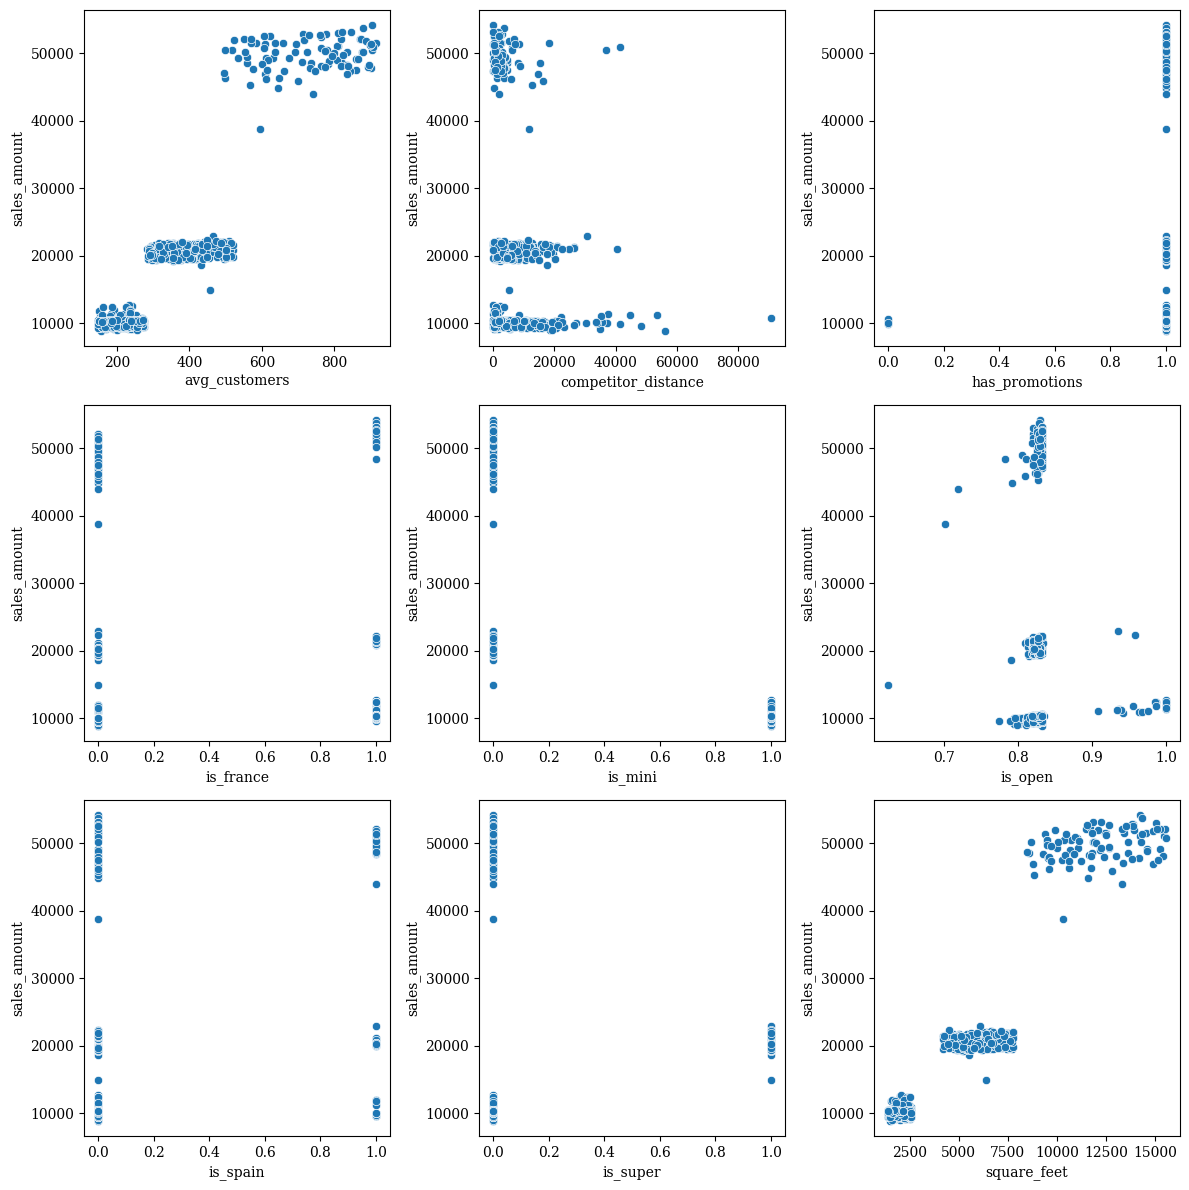

In [3421]:
fig, ax = plt.subplots(ncols = 3, nrows = 3, figsize = (12, 12))
index = 0
ax = ax.flatten()
for col_name in merged_df.columns.difference(["sales_amount"]):
	current_plot = sns.scatterplot(y = merged_df["sales_amount"], x = merged_df[col_name], ax = ax[index])
	index = index + 1
plt.tight_layout()

### correlation matrix

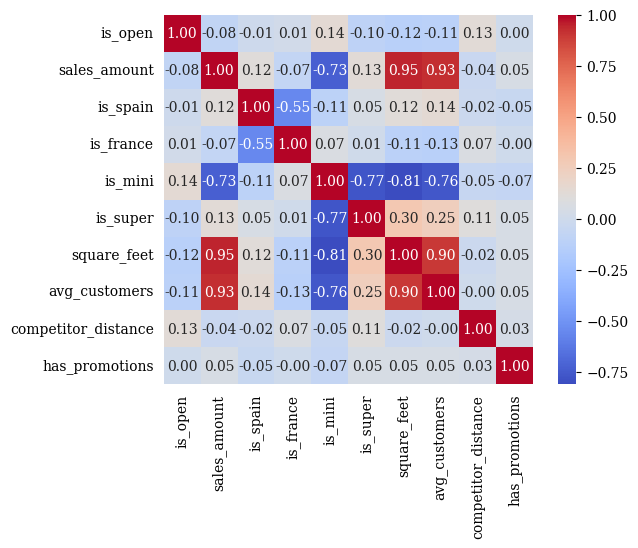

In [3422]:
ax = sns.heatmap(merged_df.corr(), annot = True, cmap = "coolwarm", fmt = ".2f", square = True)
ax.tick_params(left = False, bottom = False)

# fit linear model

In [3423]:
merged_df

,is_open,sales_amount,is_spain,is_france,is_mini,is_super,square_feet,avg_customers,competitor_distance,has_promotions
0,0.827397,10433.131548,0,1,1,0,2437,248,58,1
1,0.820513,21804.155256,0,1,0,1,6403,493,300,1
2,0.830137,21686.734197,0,1,0,1,7544,340,1598,1
3,0.820513,9728.267912,1,0,1,0,1940,165,2068,1
4,0.824658,10219.610630,0,1,1,0,1486,166,750,1
...,...,...,...,...,...,...,...,...,...,...
745,0.830137,10435.278082,0,1,1,0,1691,272,1843,1
746,0.820513,10154.048388,0,1,1,0,1462,159,547,1
747,0.827397,21847.301630,0,1,0,1,5946,488,2743,1
748,0.818681,10268.111154,0,1,1,0,1413,239,1920,1


In [3424]:
import statsmodels.api as sm
from sklearn.model_selection import KFold

# step 1: initialize kfold object to use for model evaluation
number_folds = 5
kf = KFold(n_splits = number_folds, shuffle = True, random_state = 0)

# step 2: load the boston dataset
X = merged_df.loc[:, merged_df.columns != "sales_amount"]
y = merged_df["sales_amount"]

# step 3: define a function to calculate RSE, R2, and MSE
def calculate_metrics(y_validation, y_pred, p):
	residuals = y_validation - y_pred
	RSE = (sum(residuals ** 2) / (len(residuals) - p - 1)) ** 0.5
	R2 = 1 - sum(residuals ** 2) / sum((y_validation - y_validation.mean()) ** 2)
	MSE = (residuals ** 2).mean()
	return RSE, R2, MSE

# step 4: forward selection
def forward_selection_v2(X, y):
	p = X.shape[1]
	best_models = [[]] * p
	best_metrics_k = {
		"RSE": float("inf"),
		"R2": 0,
		"MSE": float("inf"),
	}
	best_metrics = []
	for _ in range(p):
		best_metrics.append(best_metrics_k.copy())
	current_features = []
	remaining_features = list(X.columns)

	# for each number of features
	for k in range(0, p):
		print("step", k, "of", p - 1)
		# for each combination of k number of features
		for new_feature in remaining_features:
			model_features = current_features + [new_feature]
			X_subset = X[model_features]
			# add a constant for the intercept term
			X_subset = sm.add_constant(X_subset)  
			# initialize empty array to store mse for each fold
			rse_folds, r2_folds, mse_folds = 0, 0, 0
			len_mse_folds = 0
			# for each fold fit the model and estimate cv test error (using the mean of MSE in all folds)
			for train_index, validation_index in kf.split(X_subset):
				X_train, X_validation = X_subset.iloc[train_index], X_subset.iloc[validation_index]
				y_train, y_validation = y.iloc[train_index], y.iloc[validation_index]
				model = sm.OLS(y_train, X_train).fit()
				y_pred = model.predict(X_validation)
				RSE, R2, MSE = calculate_metrics(y_validation, y_pred, k + 1)
				rse_folds = rse_folds + RSE
				r2_folds = rse_folds + R2
				mse_folds = mse_folds + MSE
				len_folds = len_mse_folds + 1
			cv_rse = rse_folds / len_folds
			cv_r2 = r2_folds / len_folds
			cv_mse = mse_folds / len_folds
			# if the estimation of the test error is reduced, save metrics and model
			if cv_r2 > best_metrics[k]["R2"]:
				best_metrics[k]["RSE"] = cv_rse
				best_metrics[k]["R2"] = cv_r2
				best_metrics[k]["MSE"] = cv_mse
				best_models[k] = model_features
		current_features = best_models[k]
		remaining_features = list(set(remaining_features) - set(current_features))

	return best_models, best_metrics


# step 5: calculate and display statistics for each model
best_models, best_metrics = forward_selection_v2(X, y)
r2_list = [best_metrics[k]["R2"] for k in range(X.shape[1])]
mse_list = [best_metrics[k]["MSE"] for k in range(X.shape[1])]
best_k = r2_list.index(min(r2_list))
print(best_models[best_k])

# print("-------------------")
# print("finished!")
# print("features with best model:", best_features)
# print("RSE:", best_metrics["RSE"])
# print("R2:", best_metrics["R2"])
# print("MSE:", best_metrics["MSE"])

step 0 of 8
step 1 of 8
step 2 of 8
step 3 of 8
step 4 of 8
step 5 of 8
step 6 of 8
step 7 of 8
step 8 of 8
['competitor_distance', 'is_france', 'has_promotions', 'is_open', 'is_spain', 'is_super', 'avg_customers', 'square_feet', 'is_mini']
